# Dự đoán giá nhà - Kỹ thuật hồi quy nâng cao

Tổng quan dự án

Thị trường bất động sản là một trong những thị trường được chú trọng nhất về giá cả và liên tục biến động. Đây là một trong những lĩnh vực chính để áp dụng các ý tưởng của máy học về cách cải thiện chi phí với độ chính xác cao. Mục tiêu của dự án là dự đoán giá trị thị trường của bất động sản. Hệ thống này giúp tìm giá khởi điểm cho một bất động sản dựa trên các biến đặc điểm của ngôi nhà. Bằng cách phá vỡ các khuôn mẫu thị trường và phạm vi giá trị trong quá khứ, kết hợp với những cải tiến về mặt kỹ thuật sẽ có thể dự đoán được giá trị trong tương lai. Việc này có nghĩa là dự đoán giá nhà ở **Ames** (Ames là một thành phố ở Quận Story, Iowa, Hoa Kỳ). Nó sẽ giúp khách hàng đưa các nguồn lực vào một yêu cầu mà không cần thông qua một nhà môi giới.

## Phát biểu vấn đề

Ở đây chúng ta có một vấn đề: Yêu cầu một người mua nhà ở Ames, Iowa mô tả ngôi nhà mơ ước của họ, và họ có thể sẽ không bắt đầu với chiều cao của trần nhà hoặc khoảng cách với các siêu thị gần đó. Với những mô tả này, bạn bắt đầu dự đoán giá của ngôi nhà mơ ước này sẽ là bao nhiêu.

Dựa trên thông tin đó, chúng ta có thể thấy rằng chúng ta đang giải quyết **vấn đề hồi quy**: đưa ra một đầu vào bao gồm **tất cả các đặc điểm về ngôi nhà**, trả về **giá của ngôi nhà** như một đầu ra. Lần này, chúng ta sử dụng tập dữ liệu từ một cuộc thi trên [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description). Bộ dữ liệu này chứng minh rằng có nhiều sự ảnh hưởng nhiều hơn đến việc đàm phán giá so với số lượng phòng ngủ hoặc hàng rào màu trắng. Với 79 biến số mô tả (hầu hết) mọi khía cạnh của một ngôi nhà dân dụng, chúng ta sẽ dự đoán giá cuối cùng của mỗi ngôi nhà ở Ames. Sử dụng **RMSE** (Root Mean Squared Error) giữa logarit của giá trị dự đoán và logarit của giá trị được quan sát thực làm chỉ số đo sự sai lệch, chúng ta muốn chỉ số này gần bằng 0. Đây là cách chúng ta đánh giá và chọn mô hình tốt nhất từ một loạt mô hình hồi quy với các tham số khác nhau. Mô hình có RMSE nhỏ nhất là mô hình cuối cùng của chúng ta.

Trong dự án này, chúng tôi sẽ thực hiện những việc sau:

1. Nạp dữ liệu bằng Pandas
2. Tìm số giá trị NULL trong mỗi cột
3. Bỏ một số cột vô dụng. Cũng giảm một số cột có nhiều giá trị NULL (nếu cần) 
4. Sử dụng thư viện Scaler để chuẩn hóa các dữ liệu số
5. Xử lý dữ liệu phân loại bằng Get_Dummies ()
6. Nhập các giá trị còn thiếu
7. Thực hiện chia tập Huấn luyện và tập Kiểm tra
8. Sử dụng hồi quy để tìm mô hình phù hợp với dữ liệu
9. Cải thiện hồi quy với Fine Tune
10. Phân tích kết quả
11. Cải tiến mô hình với hồi quy xếp chồng (staked regression)
12. Sử dụng mô hình được huấn luyện cuối cùng để đưa ra dự đoán

## Hiểu biết về dữ liệu

- Đầu tiên, chúng ta phải nạp tập dữ liệu

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


- Thoạt nhìn, kích thước của tập dữ liệu huấn luyện và tập dữ liệu kiểm tra tương ứng với 1460 hàng × 81 cột và 1459 hàng × 80 cột, có nghĩa là chúng ta có tổng cộng 2919 mẫu và 80 thuộc tính (đặc điểm) của các ngôi nhà. Cột cuối cùng là 'SalePrice', giá của căn nhà.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

- Thứ hai, nhiều cột trong tập dữ liệu có định dạng 'object'. Phần còn lại có định dạng 'int64' hoặc 'float'. Đối với định dạng 'object', có rất nhiều giá trị bị thiếu. Điều này không có nghĩa là "không tồn tại" giá trị cho các thuộc tính này, chúng có ý nghĩa riêng của chúng. Ví dụ: các giá trị rỗng trong 'Alley' biểu thị "No alley access". Tuy nhiên, những giá trị còn thiếu này cần được điền hoặc xóa trước khi thực hiện quá trình huấn luyện.

In [7]:
print('Number of missing values in the training dataset:',sum(train.isnull().sum()))

Number of missing values in the training dataset: 6965


In [8]:
print('Number of missing values in the test dataset:', sum(test.isnull().sum()))

Number of missing values in the test dataset: 7000


- Chúng ta sẽ vẽ đồ thị thể hiện tỉ lệ của các "missing values" của từng cột dữ liệu.

In [9]:
y = train['SalePrice']
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(5)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


In [10]:
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


Text(0.5, 1.0, 'Percent missing data by feature')

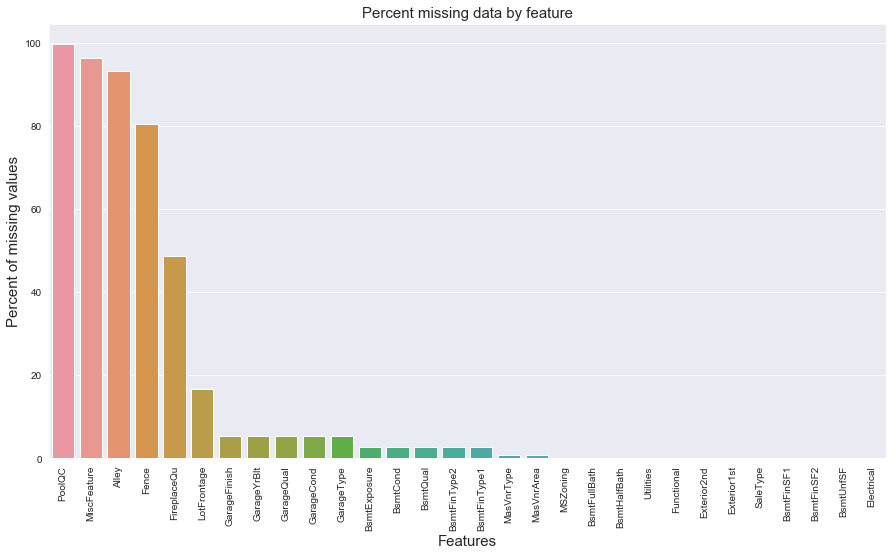

In [11]:
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

- Như vậy chúng ta có thể thấy có 4 thuộc tính có tỉ lệ missing values khá cao, lần lượt là **'PoolQC', 'Fence', 'MiscFeature'** và **'Alley'**. Ban đầu chúng ta sẽ thử loại bỏ các thuộc tính này ra khỏi tập dữ liệu phân loại để xét xem liệu chúng có làm ảnh hưởng quan trọng đến độ chính xác của mô hình hay không. Sau đó chúng ta sẽ áp dụng các kỹ thuật khác để xử lý các "missing values" này

- Dựa trên hình ảnh bên dưới, chúng ta có thể chắc chắn rằng hầu hết tất cả các ngôi nhà ở Ames đều có giá khoảng \\$100000 đến \\$200000. Và phân bố này cũng bị lệch phải. Vì các mô hình (tuyến tính) yêu thích dữ liệu với phân phối chuẩn, chúng ta cần biến đổi phân phối này và làm cho nó được chuẩn hóa hơn. Chúng ta sẽ thực hiện điều này trong phần sau sau, trong phần Đánh giá mô hình.


 mu = 180921.20 and sigma = 79415.29



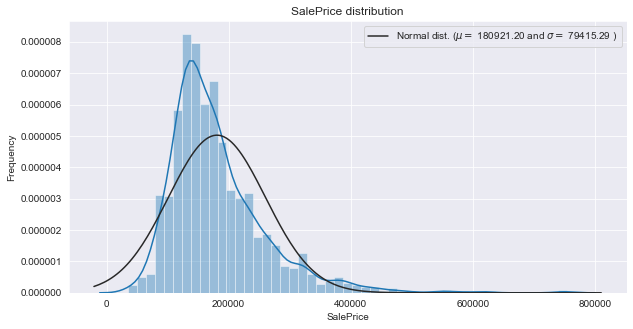

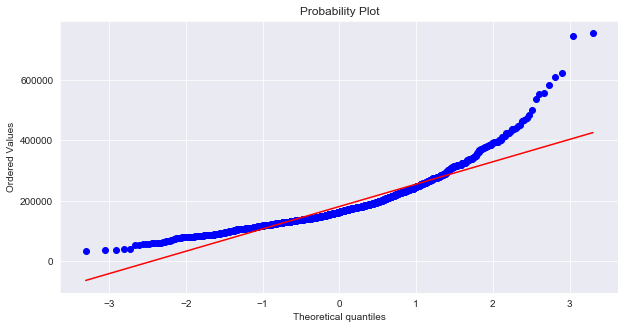

In [12]:
plt.subplots(figsize=(10,5))
sns.distplot(y, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(10,5))
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- Chúng ta cũng sẽ tìm hiểu mối tương quan giữa các tính chất của mô nhà bằng ma trận tương quan. Theo như bảng dưới mô tả thì có khá nhiều dữ liệu dạng số có độ tương quan cao với giá nhà. Mặc khác, một vài tính chất của ngôi nhà có độ tương quan thấp giá bán như **'MSSubClass', 'OverallCond', 'YrSold'** và **'MoSold'** vốn dĩ là biến phân loại mặc dù mang giá trị số. Chúng ta sẽ có cách xử lý phù hợp ở phần sau, nhưng ở phần đầu này chúng ta sẽ chỉ xử lý một cách đơn giản các biến giá trị số.

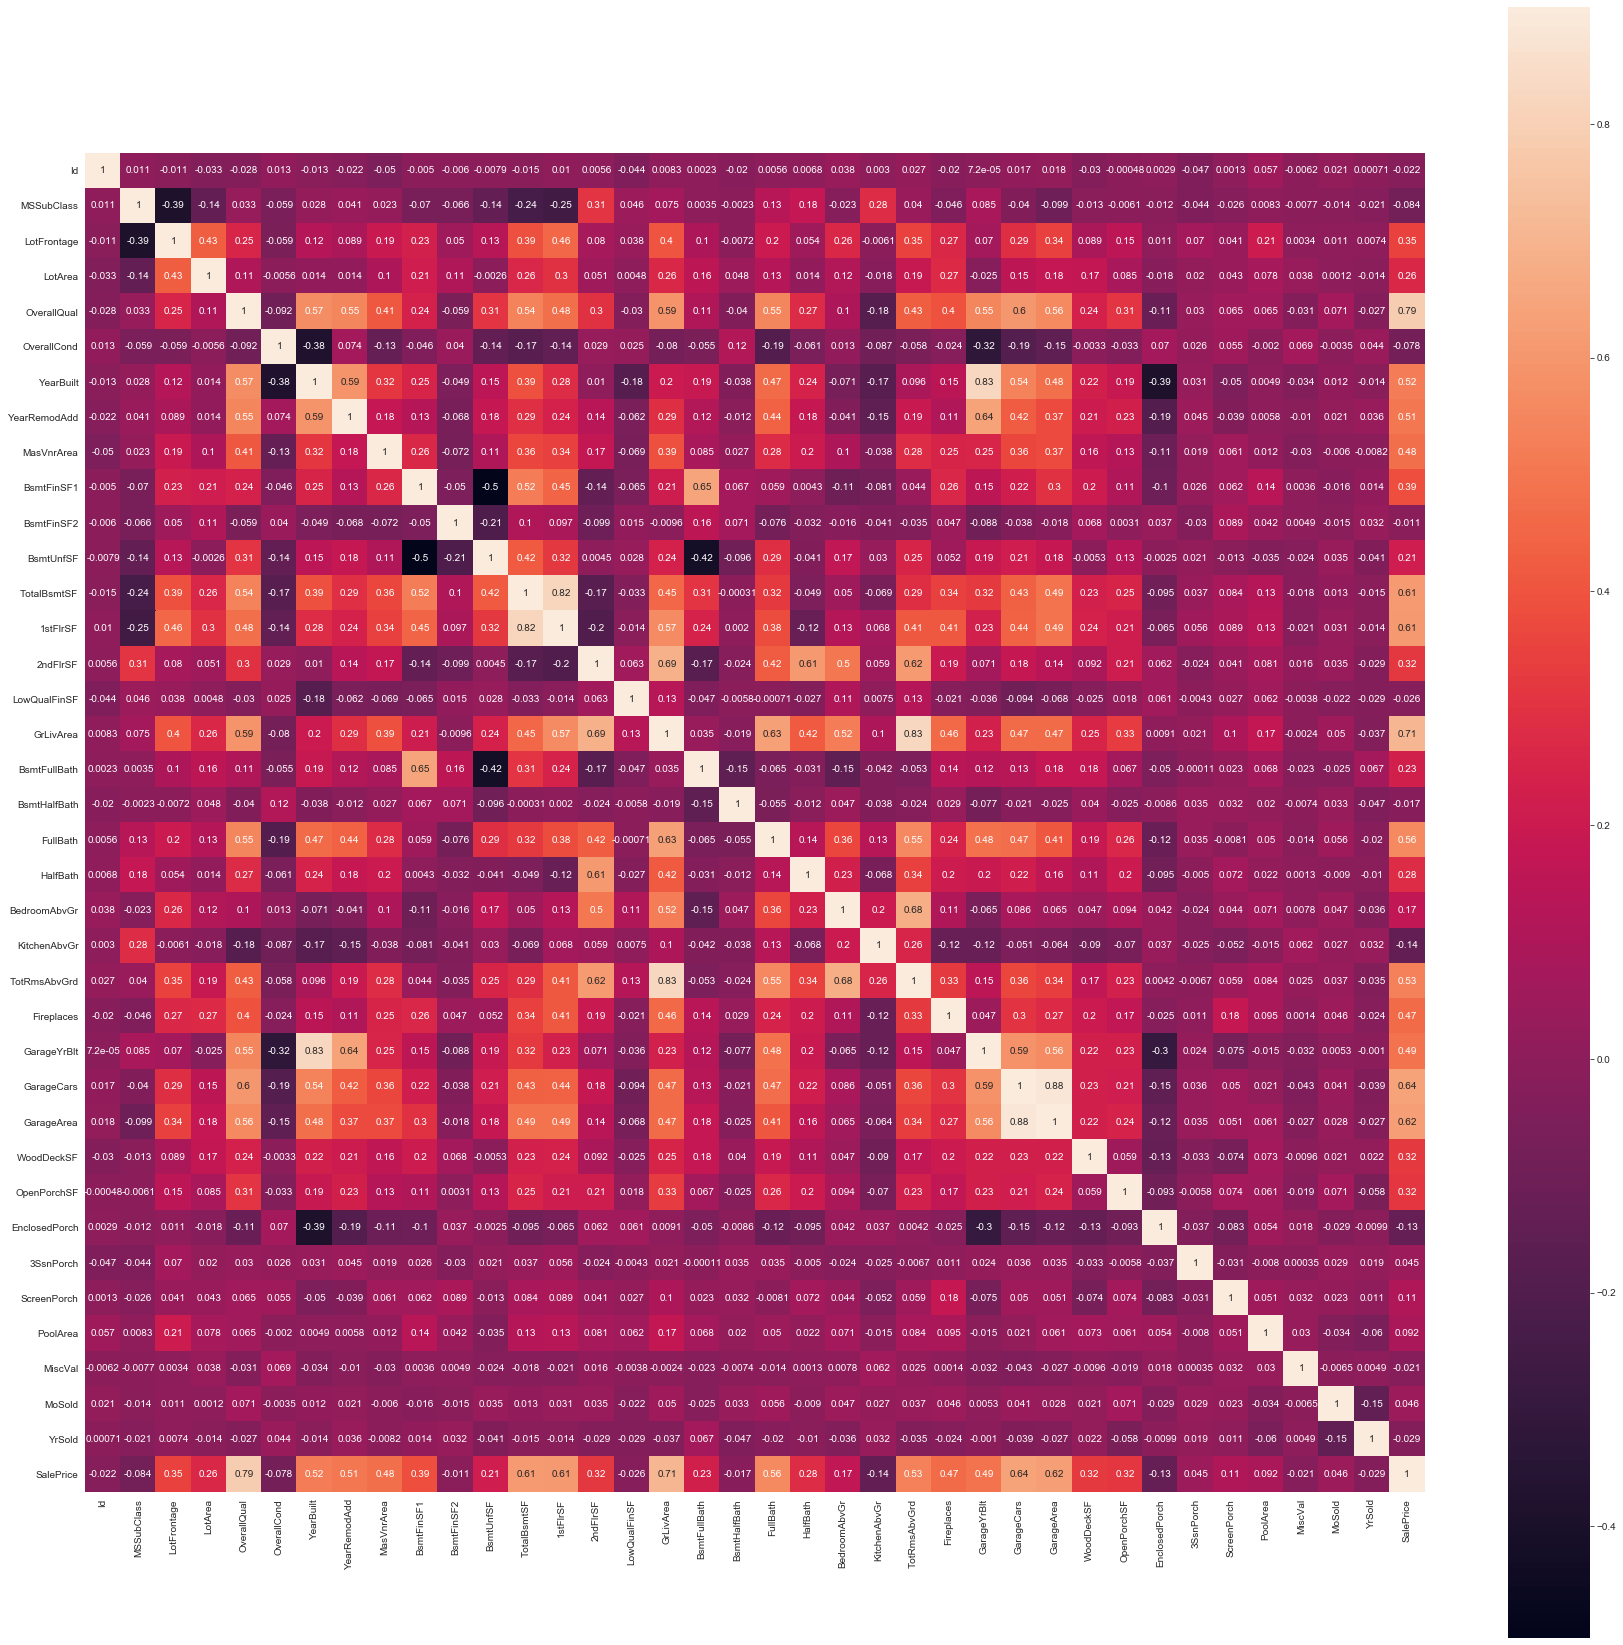

In [13]:
corrmat = train.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)

## Tiền xử lý dữ liệu

- Bây giờ chúng ta bắt đầu quá trình làm sạch dữ liệu, sau đó chúng ta sẽ xử lý các giá trị dữ liệu Số và Phân loại riêng biệt

- Chúng ta sẽ bỏ một số cột vô dụng như 'Id' và những cột có rất nhiều giá trị bị thiếu như thể hiện trong hình trên

In [14]:
drop_column = ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'Id']

# 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', 
#              '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

In [15]:
train = train.drop(columns=drop_column, axis=1)
test = test.drop(columns=drop_column, axis=1)

In [16]:
train = train.drop(['SalePrice'],axis=1)

In [17]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [18]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal


- Kế tiếp, chúng ta sẽ chia các cột dữ liệu vào 2 loại chính: Dữ liệu số ('int64' hoặc 'float64') và Phân loại ('object')

In [19]:
cat_train=[cat for cat in train.columns if train[cat].dtype=='object'] # Categorical
num_train=[cat for cat in train.columns if train[cat].dtype=='int64' or train[cat].dtype=='float64'] # Numerical

# cat_train
# num_train

In [20]:
cat_test=[cat for cat in test.columns if test[cat].dtype=='object'] # Categorical
num_test=[cat for cat in test.columns if test[cat].dtype=='int64' or test[cat].dtype=='float64'] # Numerical

# cat_test
# num_test

In [21]:
cat_test == cat_train

True

- Chúng ta sử dụng thư viện Scaler để chuẩn hóa các giá trị số để tránh các vấn đề khớp quá mức (overfitting)

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()
train[num_train] = ss.fit_transform(train[num_train])
test[num_test] = ss.transform(test[num_test])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073375,RL,-0.208034,-0.207142,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,WD,Normal
1,-0.872563,RL,0.409895,-0.091886,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,WD,Normal
2,0.073375,RL,-0.084449,0.073480,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,WD,Normal
3,0.309859,RL,-0.414011,-0.096897,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,WD,Abnorml
4,0.073375,RL,0.574676,0.375148,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,WD,Normal


In [23]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.872563,RH,0.409895,0.110763,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,-0.087688,-0.119110,1.64521,WD,Normal
1,-0.872563,RL,0.451090,0.375850,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,25.116309,-0.119110,1.64521,WD,Normal
2,0.073375,RL,0.162723,0.332053,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,1.64521,WD,Normal
3,0.073375,RL,0.327504,-0.054002,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,1.64521,WD,Normal
4,1.492282,RL,-1.114330,-0.552407,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0.533564,-0.359325,-0.116339,2.313293,-0.068692,-0.087688,-1.969111,1.64521,WD,Normal


- Sử dụng hàm Get_Dummies() để mã hóa dữ liệu dạng Phân loại

In [24]:
dummy = pd.concat([train,test],axis=0)
dummy

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073375,RL,-0.208034,-0.207142,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,WD,Normal
1,-0.872563,RL,0.409895,-0.091886,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,WD,Normal
2,0.073375,RL,-0.084449,0.073480,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,WD,Normal
3,0.309859,RL,-0.414011,-0.096897,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,WD,Abnorml
4,0.073375,RL,0.574676,0.375148,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.438219,RM,-2.020626,-0.859988,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,-1.367655,WD,Normal
1455,2.438219,RM,-2.020626,-0.864197,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.342128,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,-1.367655,WD,Abnorml
1456,-0.872563,RL,3.705515,0.950423,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,-1.367655,WD,Abnorml
1457,0.664586,RL,-0.331620,-0.007600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.221343,-0.359325,-0.116339,-0.270208,-0.068692,1.323736,0.250891,-1.367655,WD,Normal


In [25]:
dummy = pd.get_dummies(dummy, columns=cat_train)
dummy

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,0,0,0,1,1,0,0,0,0,0
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.438219,-2.020626,-0.859988,-1.518467,1.280685,-0.041991,-0.720298,-0.572835,-0.973018,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1455,2.438219,-2.020626,-0.864197,-1.518467,-0.517200,-0.041991,-0.720298,-0.572835,-0.420316,-0.288653,...,0,0,0,1,1,0,0,0,0,0
1456,-0.872563,3.705515,0.950423,-0.795151,1.280685,-0.373198,0.539493,-0.572835,1.711535,-0.288653,...,0,0,0,1,1,0,0,0,0,0
1457,0.664586,-0.331620,-0.007600,-0.795151,-0.517200,0.686666,0.345679,-0.572835,-0.233889,-0.288653,...,0,0,0,1,0,0,0,0,1,0


In [26]:
train1= dummy.iloc[0:1460]
test1= dummy.iloc[1460:]
# train1
train1.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,0,0,0,1,1,0,0,0,0,0
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,0,0,0,1,0,0,0,0,1,0


In [27]:
test1.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.872563,0.409895,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.572835,0.053428,0.604293,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,0.451090,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.023838,1.051363,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,0.162723,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.572835,0.761852,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,0.073375,0.327504,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.462340,0.347326,-0.288653,...,0,0,0,1,0,0,0,0,1,0
4,1.492282,-1.114330,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.572835,-0.396190,-0.288653,...,0,0,0,1,0,0,0,0,1,0


- Sau đó, chúng ta kết hợp hai tập dữ liệu số và phân loại sau khi đã xử lý riêng biệt.

In [28]:
train2 = pd.concat([train,train1],axis=1)
test2 = pd.concat([test,test1],axis=1)
train2.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,RL,-0.208034,-0.207142,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,RL,0.409895,-0.091886,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,RL,-0.084449,0.073480,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,0,0,0,1,0
3,0.309859,RL,-0.414011,-0.096897,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,1,1,0,0,0,0,0
4,0.073375,RL,0.574676,0.375148,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,1,0,0,0,0,1,0


In [29]:
test2.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.872563,RH,0.409895,0.110763,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,RL,0.451090,0.375850,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,RL,0.162723,0.332053,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,0,0,0,1,0
3,0.073375,RL,0.327504,-0.054002,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,0,0,0,1,0
4,1.492282,RL,-1.114330,-0.552407,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0,0,0,1,0,0,0,0,1,0


- Và xóa các cột dữ liệu phân loại ban đầu

In [30]:
train = train2.drop(cat_train,axis=1)
test = test2.drop(cat_test,axis=1)
# test123=test.copy()
# train
# id=test['Id'].iloc[:,1]
# id
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,0,0,0,1,1,0,0,0,0,0
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,0,0,0,1,0,0,0,0,1,0


In [31]:
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.872563,0.409895,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.572835,0.053428,0.604293,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,0.451090,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.023838,1.051363,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,0.162723,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.572835,0.761852,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,0.073375,0.327504,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.462340,0.347326,-0.288653,...,0,0,0,1,0,0,0,0,1,0
4,1.492282,-1.114330,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.572835,-0.396190,-0.288653,...,0,0,0,1,0,0,0,0,1,0


In [32]:
X = train
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,0,0,0,1,0,0,0,0,1,0
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,0,0,0,1,0,0,0,0,1,0
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,0,0,0,1,1,0,0,0,0,0
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.331620,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.572835,-0.973018,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1456,-0.872563,0.615871,0.266407,-0.071836,0.381743,0.222975,0.151865,0.084610,0.759659,0.722112,...,0,0,0,1,0,0,0,0,1,0
1457,0.309859,-0.166839,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.572835,-0.369871,-0.288653,...,0,0,0,1,0,0,0,0,1,0
1458,-0.872563,-0.084449,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.572835,-0.865548,6.092188,...,0,0,0,1,0,0,0,0,1,0


- Điền các giá trị trung bình của từng tính chất vào các giá trị còn thiếu của tính chất đó bằng cách sử dụng hàm SimpleImputer(), (mặc định của SimpleImputer là 'mean')

In [33]:
from sklearn.impute import SimpleImputer
si = SimpleImputer()
X = si.fit_transform(X)
test = si.fit_transform(test)
# X
test

array([[-0.87256276,  0.40989452,  0.11076257, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87256276,  0.45108977,  0.37584985, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07337496,  0.16272298,  0.33205282, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.87256276,  3.70551504,  0.95042275, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66458604, -0.3316201 , -0.00759964, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07337496,  0.16272298, -0.08918038, ...,  0.        ,
         1.        ,  0.        ]])

- Sau đó chia tập dữ liệu thành tập huấn luyện và tập kiểm tra.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train

131     244000
1179     93000
23      129900
202     112000
512     129900
         ...  
159     320000
1257     99900
1189    189000
197     235000
357     134000
Name: SalePrice, Length: 1168, dtype: int64

## Xây dựng mô hình

- Định nghĩa chỉ số đo mức độ hiệu quả của mô hình (metric). Trong trường hợp này, đó là RSME

In [35]:
from sklearn import metrics

def print_evaluate(true, predict):  
    mae = metrics.mean_absolute_error(np.log(true), np.log(predict))
    mse = metrics.mean_squared_error(np.log(true), np.log(predict))
    rmse = np.sqrt(metrics.mean_squared_error(np.log(true), np.log(predict)))
    r2_square = metrics.r2_score(true, predict)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

- Mô hình cơ sở của chúng ta là hồi quy Ridge với các tham số: alpha = 100, solver = 'cholesky', tol = 0.0001, random_state = 42

In [36]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)

test_predict = model.predict(X_test)
train_predict = model.predict(X_train)

print('Test set evaluation:\n')
print('_____________________________________')
print_evaluate(y_test, test_predict)

print('====================================')

print('Train set evaluation:\n')
print('_____________________________________')
print_evaluate(y_train, train_predict)

Test set evaluation:

_____________________________________
MAE: 0.10217483372606456
MSE: 0.019555478548966842
RMSE: 0.13984090441986866
R2 Square 0.8526920888337903
Train set evaluation:

_____________________________________
MAE: 0.0940769642875162
MSE: 0.01833910278259576
RMSE: 0.13542194350472067
R2 Square 0.8684226261923615


In [37]:
submission = pd.DataFrame(model.predict(test), columns=['SalePrice'])
submission

,SalePrice
0,104723.809385
1,139700.590177
2,168977.776373
3,193843.198041
4,195412.797262
...,...
1454,74603.802312
1455,76510.314174
1456,165491.638847
1457,105720.494985


In [38]:
submission.insert(loc=0, column='id', value=[i for i in range(1461, 2920)])

In [39]:
submission.to_csv('submission.csv', index=False)

**Điểm số trên Kaggle: 0.14811, top 61%**

## Đánh giá hiệu quả mô hình

- Nạp các thư viện cần thiết cho việc đánh giá mô hình

In [40]:
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_squared_log_error

- Plot learning_curve: chúng ta sẽ dùng hàm learning_curve để vẽ đồ thị mô tả mối quan hệ của tập huấn luyện (kiểm định) và chỉ số RMSE

In [42]:
def learning_curve(model, X_train, y_train, X_test, y_test, param_grid, cv=5, Random=False, step=1, **kwargs):
    
    if Random:
        grid = RandomizedSearchCV(model(**kwargs), param_distributions=param_grid, cv=cv, 
                                  scoring='neg_mean_squared_error', n_iter=100, n_jobs=-1)
    else:
        grid = GridSearchCV(model(**kwargs), param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f'\n\nbest model parameters is {grid.best_params_}\n')
    best_params = {}
    for key, value in grid.best_params_.items():
        if key not in ['n_iter_no_change', 'validation_fraction']: 
            best_params[key] = value
    
    train_loss = []
    val_loss = []
    
    for i in range(0, len(X_train), step):
        model_ = model(**best_params)
        model_.fit(X_train[:i+1], y_train[:i+1])
        training_loss = np.sqrt(mean_squared_error(np.log(np.abs(y_train[:i+1])), np.log(np.abs(model_.predict(X_train[:i+1])))))
        validation_loss = np.sqrt(mean_squared_error(np.log(np.abs(y_test)), np.log(np.abs(model_.predict(X_test)))))
        train_loss.append(training_loss)
        val_loss.append(validation_loss)
    
    cv = RepeatedKFold(n_splits=8, n_repeats=2)
    scores = cross_val_score(model(**best_params), X_train, np.log(y_train), cv=cv, 
                             n_jobs=-1, scoring='neg_mean_squared_error')
    scores = np.sqrt(np.abs(scores))
    
    model_ = model(**best_params)
    model_.fit(X_train, y_train)
    print(f'RMSE is :{np.sqrt(abs(mean_squared_error(np.log(y_test), np.log(model_.predict(X_test)))))}')
        
        
    plt.figure(figsize=(15, 8))
    
    plt.subplot(121)
    plt.plot([i for i in range(0, len(X_train), step)], train_loss, 'r-', linewidth=1, label='Training Loss')
    plt.plot([i for i in range(0, len(X_train), step)], val_loss, 'b-', linewidth=1, label='Validation loss')
    plt.xlabel('Training set size', fontsize=15, labelpad=10)
    plt.ylabel('RMSE', fontsize=15, labelpad=10)
    plt.legend(fontsize=12)
    
    plt.subplot(122)
    plt.boxplot(scores, showmeans=True)
    
    plt.show()
    return best_params

### Ridge Regression

In [43]:
param_grid_ridge = {'alpha': np.arange(1, 101), 'solver': ['cholesky'], 'tol': [0.0001]}



best model parameters is {'alpha': 19, 'solver': 'cholesky', 'tol': 0.0001}

RMSE is :0.14085867263014562


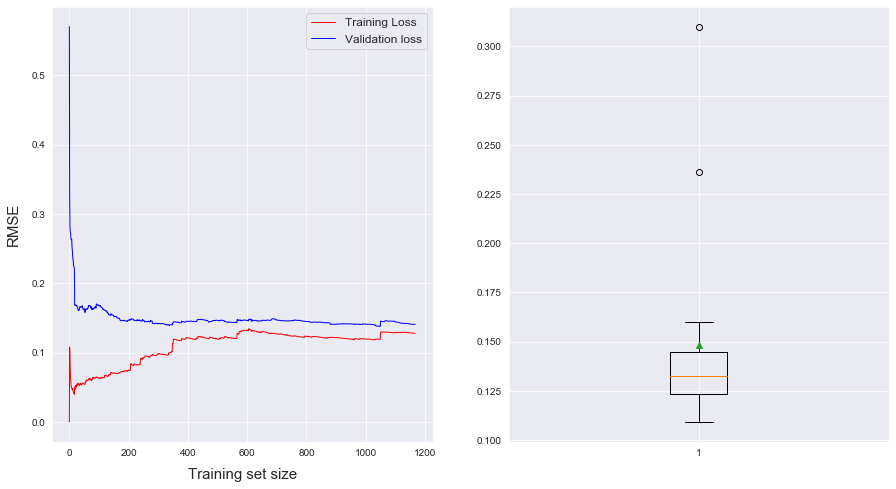

In [44]:
best_params_ridge = learning_curve(Ridge, 
                             X_train, 
                             y_train, 
                             X_test, 
                             y_test, 
                             param_grid_ridge, 
                             cv=5, random_state=42)       

**RMSE của mô hình cũ (Tập kiểm định): 0.13984090441986866  
  RMSE của mô hình mới (Tập kiểm định): 0.14085867263014562**

In [45]:
model = Ridge(alpha = best_params_ridge['alpha'], tol = 0.0001, random_state=42)
model.fit(X_train, y_train)

Ridge(alpha=19, random_state=42, tol=0.0001)

In [46]:
submission = pd.DataFrame(model.predict(test), columns=['SalePrice'])
submission.insert(loc=0, column='id', value=[i for i in range(1461, 2920)])
submission.to_csv('submission_ridge.csv', index=False)

### Lasso Regression

In [47]:
param_grid_lasso = {'alpha': np.arange(1, 100)}



best model parameters is {'alpha': 99}



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3698306.4548688084, tolerance: 1140050.0
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2236890.9350208305, tolerance: 1239380.6666666667
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4482743.217435839, tolerance: 139

RMSE is :0.14487406622373888


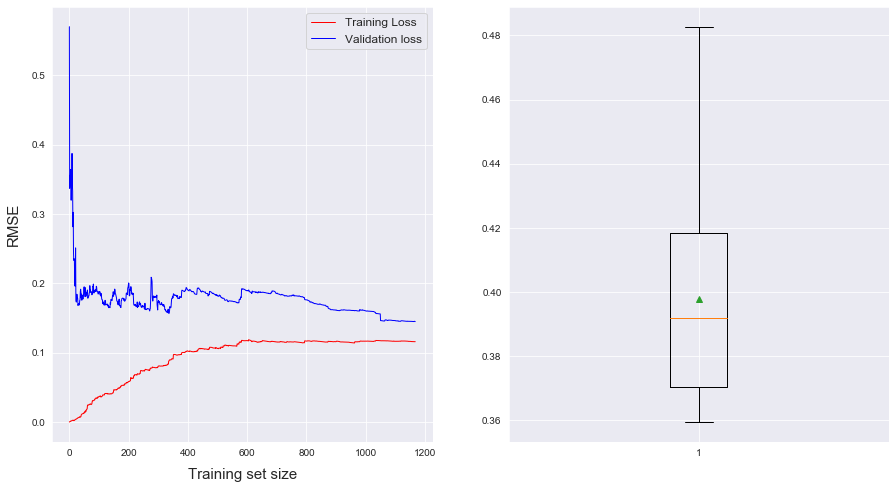

In [48]:
best_params_lasso = learning_curve(Lasso, 
                             X_train, 
                             y_train, 
                             X_test, 
                             y_test, 
                             param_grid_lasso, 
                             cv=5, random_state=42)  

**RMSE của mô hình cũ (Tập kiểm định): 0.13984090441986866  
  RMSE của mô hình mới (Tập kiểm định): 0.14487406622373888**

In [49]:
model = Lasso(alpha = best_params_lasso['alpha'], tol = 0.0001, random_state=42)
model.fit(X_train, y_train)

Lasso(alpha=99, random_state=42)

In [50]:
submission = pd.DataFrame(model.predict(test), columns=['SalePrice'])
submission.insert(loc=0, column='id', value=[i for i in range(1461, 2920)])
submission.to_csv('submission_lasso.csv', index=False)

### Elastic Regression

In [51]:
param_grid_elastic = {'alpha': 0.01*np.arange(1, 100),
                      'l1_ratio': 0.0001*np.arange(100)}

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471219937054.658, tolerance: 707397692.0703596
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1425991298.5130312, tolerance: 18985104.72745098
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5353415411.743521, tolerance



best model parameters is {'l1_ratio': 0.003, 'alpha': 0.03}



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46130607907.38657, tolerance: 164678387.22427773
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94081560720.04207, tolerance: 190175860.2432775
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120003299863.28865, tolerance: 230505481.07134464
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

RMSE is :0.1393864364198722


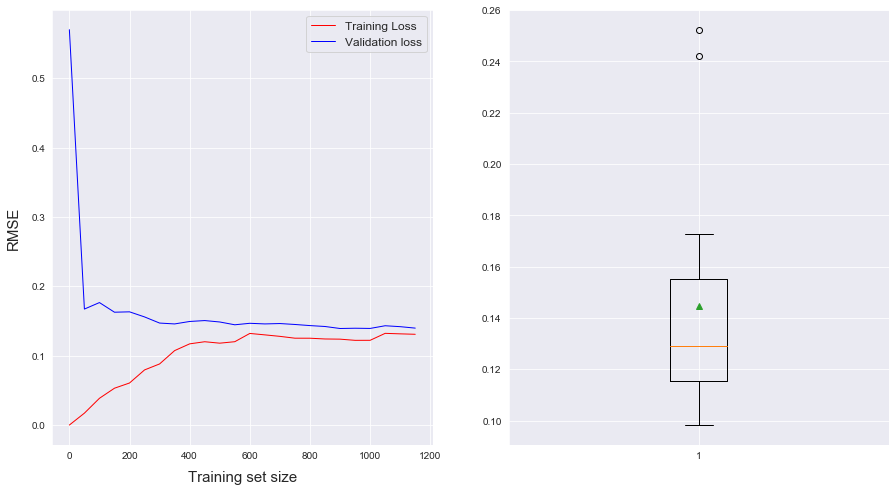

In [52]:
best_params_elastic = learning_curve(ElasticNet, 
                             X_train, 
                             y_train, 
                             X_test, 
                             y_test, 
                             param_grid_elastic, 
                             cv=5, Random=True, step=50)  

**RMSE của mô hình cũ (Tập kiểm định): 0.13984090441986866  
  RMSE của mô hình mới (Tập kiểm định): 0.1393864364198722**

In [55]:
model = ElasticNet(alpha = best_params_elastic['alpha'], l1_ratio = best_params_elastic['l1_ratio'], tol = 0.0001, random_state=42)
model.fit(X_train, y_train)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471219937054.658, tolerance: 707397692.0703596
  positive)


ElasticNet(alpha=0.03, l1_ratio=0.003, random_state=42)

In [56]:
submission = pd.DataFrame(model.predict(test), columns=['SalePrice'])
submission.insert(loc=0, column='id', value=[i for i in range(1461, 2920)])
submission.to_csv('submission_elastic.csv', index=False)

**điểm số trên Kaggle: 0.14660, top 55%**

![Final Results](image_5.png)

## Hồi quy xếp chồng kết hợp với cải thiện quá trình xử lý dữ liệu

In [57]:
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

- Nạp lại tập dữ liệu

In [58]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [59]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


- Kiểm tra xem tập dữ liệu có các ngoại lệ hay không

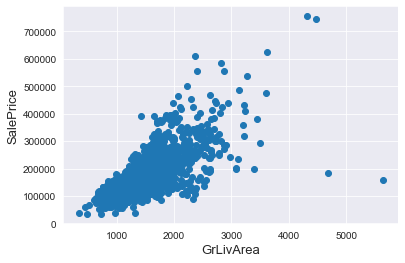

In [60]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

-Chúng ta có thể thấy ở hai góc dưới cùng bên phải có GrLivArea cực lớn lại có giá rất thấp. Những giá trị này là những giá trị ngoại lệ rất lớn. Do đó, chúng ta có thể xóa chúng (một cách an toàn).

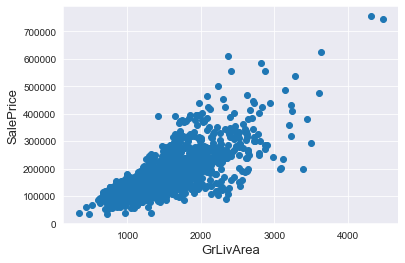

In [61]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**Note** : Có thể có những ngoại lệ khác trong tập dữ liệu huấn luyện. Tuy nhiên, việc loại bỏ tất cả chúng có thể ảnh hưởng không tốt đến các mô hình nếu cũng có những ngoại lệ trong tập dữ liệu kiểm tra.

- Kế tiếp chúng ta sẽ chuẩn hóa lại dữ liệu bằng cách sử dụng hàm log(1+x)


 mu = 12.02 and sigma = 0.40



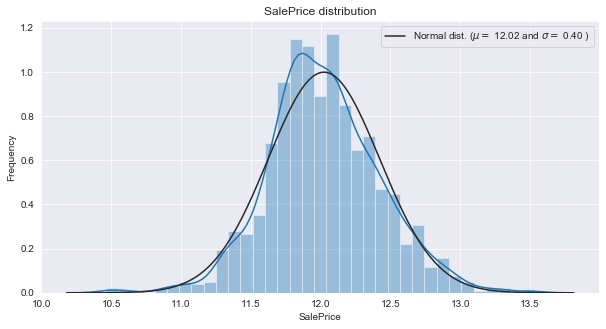

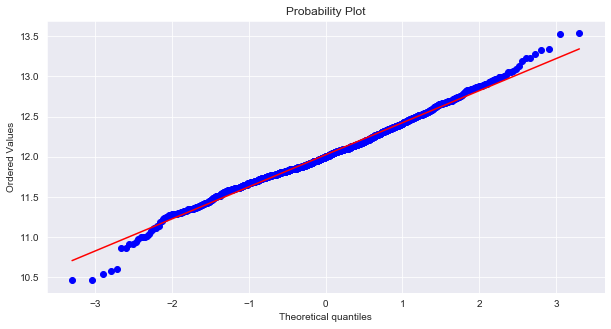

In [62]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
plt.subplots(figsize=(10,5))
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(10,5))
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Chúng ta xử lý các giá trị bị thiếu bằng cách xử lý tuần tự từng thuộc tính có giá trị bị thiếu.

- **PoolQC**: mô tả dữ liệu cho biết NA có nghĩa là "No  Pool". Điều đó khá dễ hiểu, với tỷ lệ giá trị bị thiếu rất lớn (hơn 99%) và phần lớn các ngôi nhà nói chung không có hồ bơi, thay thế dữ liệu bằng 'None'

- **MiscFeature** : mô tả dữ liệu cho biết NA có nghĩa là "no misc feature", thay thế dữ liệu bằng 'None'

- **Alley** : mô tả dữ liệu cho biết NA có nghĩa là "no alley access", thay thế dữ liệu bằng 'None'

- **Fence** : mô tả dữ liệu cho biết NA có nghĩa là "no fence", thay thế dữ liệu bằng 'None'

- **FireplaceQu** : mô tả dữ liệu cho biết NA có nghĩa là "no fireplace", thay thế dữ liệu bằng 'None'

- **MSSubClass** : Na rất có thể có nghĩa là "no building class". Chúng ta có thể thay thế các giá trị bị thiếu bằng "None"

- **GarageType, GarageFinish, GarageQual và GarageCond** : thay thế dữ liệu bằng 'None'

In [63]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [64]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [65]:
all_data["Alley"] = all_data["Alley"].fillna("None")

In [66]:
all_data["Fence"] = all_data["Fence"].fillna("None")

In [67]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [68]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [69]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **LotFrontage** : we can **điền các giá trị còn thiếu bằng giá trị trung bình LotFrontage của khu vực lân cận**. (do các ngôi nhà trong các khu vực gần nhau thường có diện tích tương đồng)

In [70]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarageYrBlt, GarageArea and GarageCars** : Thay thế dữ liệu bị thiếu bằng 0 (Vì Không có ga ra đồng nghĩa không có ô tô nào trong ga ra đó và diện tích của ga ra bằng 0.)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : Thay thế dữ liệu bị thiếu bằng 0 (ý nghĩa tương tự như ga ra)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : Thay thế dữ liệu bị thiếu bằng 'None' (ý nghĩa tương tự như ga ra)

In [71]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [72]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [73]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA rất có thể có nghĩa là không có ván xây cho những ngôi nhà này. Chúng ta có thể điền 0 cho Area và None cho Type.

In [74]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' là giá trị phổ biến nhất. Vì vậy, chúng ta có thể điền vào các giá trị còn thiếu bằng 'RL'

In [75]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : Đối với thuộc tính phân loại này, tất cả các bản ghi đều là "AllPub", ngoại trừ một "NoSeWa" và 2 NA. **Do đó thuộc tính này sẽ không giúp ích trong việc thiết lập mô hình dự đoán**. Nên chúng ta có thể loại bỏ nó một cách an toàn.

In [76]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : mô tả dữ liệu cho biết NA có nghĩa là chức năng điển hình, chúng ta điền các giá trị bị thiếu bằng "Typ"

- **Electrical** : Nó chỉ có một giá trị NA. Vì giá trị của thuộc tính này chủ yếu là 'SBrkr', nên chúng ta có thể đặt giá trị đó cho giá trị còn thiếu.

- **KitchenQual**: tương tự với Electrical, chúng ta đặt 'TA' (là giá trị phổ biến nhất) cho dữ liệu bị thiếu trong KitchenQual.

- **Exterior1st và Exterior2nd** : tương tự với Electrical, điền các giá trị bị thiếu bằng giá trị phổ biến nhất

- **SaleType** : tương tự với Electrical, điền các giá trị bị thiếu bằng giá trị phổ biến nhất

In [77]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [78]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [79]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [80]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [81]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- Kiểm tra các giá trị bị thiếu còn tồn tại hay không

In [82]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Tập dữ liệu đã không còn các giá trị bị thiếu.

- Tiếp theo, chúng ta biến đổi một số biến giá trị số thực ra là biến phân loại

In [83]:
#MSSubClass is transformed into categorical features.
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

- Mã hóa nhãn (Label encoding) một số biến phân loại.

In [84]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 79)


- Thêm một vài thuộc tính mới

Vì các đặc điểm liên quan đến diện tích rất quan trọng để xác định giá nhà nên chúng ta bổ sung thêm một đặc điểm nữa là tổng diện tích tầng hầm, diện tích tầng 1 và tầng 2 của mỗi ngôi nhà

In [85]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

- Co dãn các thuộc tính số.

In [86]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


- Thực hiện Box Cox Transformation của một vài thuộc tính có độ skewness cao (skewness > 0.75)

In [87]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 60 skewed numerical features to Box Cox transform


- Lần nữa, mã hóa các thuộc tính phân loại bằng get_dummies()

In [88]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 222)


- Chia tập huấn luyện và tập kiểm tra mới

In [89]:
train = all_data[:ntrain]
test = all_data[ntrain:]

- Xác định chiến lược xác thực chéo. Sử dụng hàm **cross_val_score** của Sklearn. Tuy nhiên, hàm này không có thuộc tính xáo trộn, chúng ta thêm bào một dòng mã, để xáo trộn tập dữ liệu trước khi xác thực chéo. Điều này giúp có được kết quả khách quan hơn.

In [91]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, np.log(y_train), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### Các mô hình cơ sở

 - **Lasso Regression** : Mô hình này có thể rất nhạy cảm với các ngoại lệ. Do đó chúng tôi sử dụng phương thức Robustscaler() của sklearn để chuẩn hóa dữ liệu.

In [92]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** : tương tự mô hình Lasso

In [93]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [94]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

In [95]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [96]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- **LightGBM** :

In [97]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Mô hình Average Ensemble

- Cách tiếp cận Ensemble đầu tiên: chúng ta sử dụng giá trị dự đoán trung bình của các mô hình cơ sở để đưa ra giá trị dự đoán cuối cùng. Chúng ta sẽ xây dựng một đối tượng mới để đại diện cho mô hình xếp chồng này.

In [98]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [99]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1198 (0.0144)



- Tuy nhiên mô hình này vẫn chưa thật sự tốt lắm, nên chúng ra sẽ sử dụng một cách tiếp cận nâng cao hơn

### Thêm vào Meta-model trong mô hình Stacking

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Hình lấy từ [Faron](https://www.kaggle.com/getting-started/18153#post103381))

#### Mô hình Stacking mới

In [100]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        
        return self.meta_model_.predict(meta_features)

-  **Định nghĩa lại hàm chỉ số RSME**

In [101]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

- **Stacked Regressor** : với các mô hình cơ sở là Elastic Net, Gradient Boosting và Kernel Ridge. Còn mô hình meta là Lasso

In [103]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1197 (0.0140)


In [104]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y_train, stacked_train_pred))

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317317994432.93945, tolerance: 724013764.6007946
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342167430326.232, tolerance: 740459574.5039065
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377633059497.4278, tolerance: 786224914.7680945
  positive)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

0.0724015627212148


- **XGBoost** :

In [105]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = model_xgb.predict(test)
print(rmse(y_train, xgb_train_pred))

[13:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.02424348088918143


- ****LightGBM** :

In [106]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = model_lgb.predict(test.values)
print(rmse(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.08501746848791401


- Lưu các giá trị dự đoán của các mô hình để dùng cho mô hình tập hợp ở phía sau

In [107]:
stacked_pred = stacked_averaged_models.predict(test.values)

In [108]:
lgb_pred = model_lgb.predict(test.values)

In [110]:
xgb_pred = model_xgb.predict(test)

**Giá trị dự đoán của mô hình Ensemble:**

Tiếp theo, Chúng tôi sử dụng một mô hình tập hợp để đưa ra dự đoán cuối cùng:

**ensemble_model = stacked_model\*0.70 + xgb_model\*0.15 + lgb_model\*0.15**

In [111]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [112]:
ensemble

array([131375.09553297, 159710.37007011, 190795.24009557, ...,
       168834.16482031, 128304.49873921, 217392.7459132 ])

In [113]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmse(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.06262842977949089


In [114]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_stacked.csv',index=False)

In [115]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = lgb_pred
sub.to_csv('submission_LGB.csv',index=False)

In [116]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission_XGB.csv',index=False)

**điểm số trên Kaggle: 0.12709, top 24%**

- **Note:** Tuy mô hình Ensemble cho ra kết quả huấn luyện khá tốt, tuy nhiên khi kiểm tra so với thực tế thì mô hình thành phần **LightGBM** của mô hình Ensemble lại cho ra kết quả tốt hơn (như hình dưới). Điều này có nghĩa là ta đã đặt trọng số quá cao cho các mô hình thành phần vốn không quan trọng (kết quả dự đoán không tốt). Ta có thể cải thiện điều này bằng cách tạo ra một mô hình Ensemble khác với trọng số chủ yếu nằm ở mô hình **LightGBM**

![Stacked Results](image_2.png)

### Mô hình Ensemble khác

**ensemble_model = stacked_model\*0.1 + xgb_model\*0.05 + lgb_model\*0.85**

In [118]:
ensemble_another = stacked_pred*0.1 + xgb_pred*0.05 + lgb_pred*0.85

In [119]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble_another
sub.to_csv('submission_stacked_another.csv',index=False)

**điểm số trên Kaggle: 0.12547, top 19%**

- Như chúng ta dự đoán, lần này kết quả của mô hình Ensemble mới tốt hơn phiên bản cũ

![Another Stacked Results](image_3.png)

## Thảo luận về dự án

Như bạn có thể thấy, mô hình Ensemble của chúng ta có kết quả tốt hơn các mô hình cơ sở riêng lẻ (bao gồm cả mô hình Stacking). Sau một số kỹ thuật xử lý, sử dụng các mô hình Stacking và mô hình Ensemble; điểm số giảm từ **0.14811 (top 61%)** xuống **0.14660**, rồi từ **0.14660** xuống **0,12547 (top 19%)**. Kết quả đó cho thấy cách tiếp cận này đã có hiệu quả. Trong suốt dự án này, chúng ta đã nhận ra rằng  **mô hình Hồi quy** có hai tác vụ khó khăn nhất để giải quyết nếu muốn xây dựng một mô hình tốt (những tác vụ này cần kinh nghiệm từ các chuyên gia để làm việc với):

- Cái đầu tiên là **dữ liệu**, dữ liệu chúng ta sở hữu có thể không đủ hoặc chúng có thể chứa các giá trị bị thiếu trong một số thuộc tính. Đối với vấn đề này, chúng ta có thể sử dụng một số kỹ thuật bao gồm **điền dữ liệu còn thiếu, thêm một số tính năng hoặc xử lý dữ liệu phân loại (và số)** theo những cách cụ thể.



- Thứ hai là **chọn đúng mô hình**. Trong thực tế, dữ liệu có một số lượng lớn các thuộc tính (là thứ nguyên của dữ liệu). Vì vậy, thực sự khó để chọn được mô hình phù hợp bởi trực giác của con người nếu không có kinh nghiệm. Ngay cả khi bạn chọn đúng mô hình thì còn rất nhiều việc phải làm, bạn nên điều chỉnh các thông số (với tìm kiếm lưới hoặc tìm kiếm ngẫu nhiên) của mô hình này để tránh hiện tượng overfitting và underfitting. Trong dự án này, chúng ta sử dụng **mô hình Stacking và mô hình Ensemble** để giải quyết vấn đề này.

Mặc dù kết quả là khá tốt, chúng ta có thể thực hiện những cách khác để có một mô hình tốt hơn nữa. Chúng ta có thể xây dựng một mô hình hồi quy khác hoặc chúng ta có thể thực hiện một số kỹ thuật làm sạch hiện đại hơn để có dữ liệu tốt hơn.